<a href="https://colab.research.google.com/github/thirza258/myKaggle/blob/main/WikipediaGraphRAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Wikipedia Links Algorithm with graph RAG and FAISS RAG Submission


In [ ]:
!pip install nx-arangodb
!pip install nx-cugraph-cu12 --extra-index-url https://pypi.nvidia.com
!pip install --upgrade langchain langchain-community langchain-openai langgraph
!pip install faiss-cpu sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 56.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.6/114.6 kB 7.5 MB/s eta 0:00:00
  Attempting uninstall: networkx
    Found existing installation: networkx 3.4.2
    Uninstalling networkx-3.4.2:
      Successfully uninstalled networkx-3.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which

In [ ]:
import networkx as nx
import nx_arangodb as nxadb

import os
from google.colab import userdata

from arango import ArangoClient

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from random import randint
import re

from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from langchain_openai import ChatOpenAI
from langchain_community.graphs import ArangoGraph
from langchain_community.chains.graph_qa.arangodb import ArangoGraphQAChain
from langchain_core.tools import tool

from langchain.tools import tool
from langchain.vectorstores import FAISS
from langchain.embeddings import OpenAIEmbeddings
from langchain.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.llms import OpenAI
import chardet

[17:12:47 +0000] [INFO]: NetworkX-cuGraph is available.
INFO:nx_arangodb:NetworkX-cuGraph is available.


In [ ]:
from arango import ArangoClient
import base64

encodedCA = "LS0tLS1CRUdJTiBDRVJUSUZJQ0FURS0tLS0tCk1JSURHRENDQWdDZ0F3SUJBZ0lRSXlzVUd4M0hNazl4NzVXVHlmZ2E4akFOQmdrcWhraUc5dzBCQVFzRkFEQW0KTVJFd0R3WURWUVFLRXdoQmNtRnVaMjlFUWpFUk1BOEdBMVVFQXhNSVFYSmhibWR2UkVJd0hoY05NalV3TWpFNApNREl3TVRNd1doY05NekF3TWpFM01ESXdNVE13V2pBbU1SRXdEd1lEVlFRS0V3aEJjbUZ1WjI5RVFqRVJNQThHCkExVUVBeE1JUVhKaGJtZHZSRUl3Z2dFaU1BMEdDU3FHU0liM0RRRUJBUVVBQTRJQkR3QXdnZ0VLQW9JQkFRQ2QKOGNDcElVQTNkaHY3T0oyblFzNDZoVTZJQkpxWnk0R0ZrS1d4SXN5eWlxWGpvSVpDWFZobTV2WFNkdG1WWHBXSgpwMHVUWm1mWkt2eHcwYmFPbGM1MGJ3ZG9jOS9ZdWlXbzI3QTEzVUllS0JuSFVySVhtd3hpNm9OaFBOZG5KNHBnCkZYMXJvN2hsOHdXWENzZ1owNFV4dlJTa2FSZDliZktpeXVXVW1wU3ZkSFZJVGxMUHJQTXJjMWhGcWFmRE00STkKTGVNYkwvNkRra1hla3RyKzZVYVJSVnM1K3pqMFhLZ0xUZlNzek0zRkkxcktXS3RVczdCNlpmRzk4aHJsSW1sOQp6MWx0bTEyZk5OeDFvUkFsbEI3a0M0bFJhdmQ3NmlOTFdianBGZm4rZmxPOEpZakI2RDZ4NW95S3NNN0pWRjAxClhxYUVOU1Mrdkp0QnFaYlZNKy8xQWdNQkFBR2pRakJBTUE0R0ExVWREd0VCL3dRRUF3SUNwREFQQmdOVkhSTUIKQWY4RUJUQURBUUgvTUIwR0ExVWREZ1FXQkJSK29PYlBlMDM3VjZXRzI0b1dUbUFhb2VpQzFEQU5CZ2txaGtpRwo5dzBCQVFzRkFBT0NBUUVBaTBIREhHQjFLTXdhdUdSV2NRTUlyYjN4OFJCM083cmtLeXFnNUd3MTVoNUNEMUUyCkVaa3V4LzdPWjg1QW1jb3JCZlc2ekZGQlVtaktITjhJZWdCUGtmOXowWHJmNzYyeHFRVHRJYlZlb1Frb0hlL2kKKzd1UzY4OUhRVjNKTVM4VWYvVE5ZUjhQRWtieUdJdzBZWEFyUUIwT2I2UzVSNklOVk1kdlM3a2MrMVJyODBoZwpTT1Nsc25jcnRtQ1Jqd3J1MEFacG9DRy8xMXlWUlU1ZStsSjJNeURMNWtVS083bEFNZ0QvbXlOa2RHUFdUS1BsClk5L0FDS1JCbTRQeWZxYUVtcTVPbTNKVEtBS2xMckR2WWcxUVpDN0FPdkJ0L3BhMWNoQlRPaEloVmpsdW85c1MKUUM1YWRLcHdwcVkxVitPeis1Zlh0bUxuZDdlYW5TcVdLMER2YlE9PQotLS0tLUVORCBDRVJUSUZJQ0FURS0tLS0tCg=="
try:
    file_content = base64.b64decode(encodedCA)
    with open("cert_file.crt", "w+") as f:
        f.write(file_content.decode("utf-8"))
except Exception as e:
    print(str(e))
    exit(1)

client = ArangoClient(
    hosts="https://b3889dc81c5a.arangodb.cloud:18529", verify_override="cert_file.crt"
)

db = client.db("_system", username="root", password=userdata.get("DB_PASSWORD"))

# Note that ArangoGraph Insights Platform runs deployments in a cluster configuration.
# To achieve the best possible availability, your client application has to handle
# connection failures by retrying operations if needed.
print("ArangoDB:", db.version())

ArangoDB: 3.12.4


# Data Preprocessing

# The list of all articles.
# Article names are URL-encoded; e.g., in Java they can be decoded using java.net.URLDecoder.decode(articleName, "UTF-8").
# FORMAT:   article
#
# When publishing on this data set, please cite:
# (1) Robert West and Jure Leskovec:
#     Human Wayfinding in Information Networks.
#     21st International World Wide Web Conference (WWW), 2012.
# (2) Robert West, Joelle Pineau, and Doina Precup:
#     Wikispeedia: An Online Game for Inferring Semantic Distances between Concepts.
#     21st International Joint Conference on Artificial Intelligence (IJCAI), 2009.

In [ ]:
articles = pd.read_csv("/content/drive/MyDrive/wikispeedia_paths-and-graph/wikispeedia_paths-and-graph/articles.tsv", sep='\t', names=["article"])

articles.head()

,article
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in
1,%C3%85land
2,%C3%89douard_Manet
3,%C3%89ire
4,%C3%93engus_I_of_the_Picts


# Hierarchical categories of all articles.
# Many articles have more than one category. Some articles have no category.
# Article names are URL-encoded; e.g., in Java they can be decoded using java.net.URLDecoder.decode(articleName, "UTF-8").
# FORMAT:   article   category
#
# When publishing on this data set, please cite:
# (1) Robert West and Jure Leskovec:
#     Human Wayfinding in Information Networks.
#     21st International World Wide Web Conference (WWW), 2012.
# (2) Robert West, Joelle Pineau, and Doina Precup:
#     Wikispeedia: An Online Game for Inferring Semantic Distances between Concepts.
#     21st International Joint Conference on Artificial Intelligence (IJCAI), 2009.

In [ ]:
categories = pd.read_csv("/content/drive/MyDrive/wikispeedia_paths-and-graph/wikispeedia_paths-and-graph/categories.tsv", sep='\t', names=['article', 'category'])

categories.sample(5)

,article,category
3899,Reptile,subject.Science.Biology.Insects_Reptiles_and_Fish
1558,Energy,subject.Science.Physics.General_Physics
4001,Royal_Navy,subject.History.Military_History_and_War
320,Antigua_and_Barbuda,subject.Countries
4231,Slovakia,subject.Geography.European_Geography.European_...


# The list of all links between articles.
# Article names are URL-encoded; e.g., in Java they can be decoded using java.net.URLDecoder.decode(articleName, "UTF-8").
# FORMAT:   linkSource   linkTarget
#
# When publishing on this data set, please cite:
# (1) Robert West and Jure Leskovec:
#     Human Wayfinding in Information Networks.
#     21st International World Wide Web Conference (WWW), 2012.
# (2) Robert West, Joelle Pineau, and Doina Precup:
#     Wikispeedia: An Online Game for Inferring Semantic Distances between Concepts.
#     21st International Joint Conference on Artificial Intelligence (IJCAI), 2009.

In [ ]:
links = pd.read_csv("/content/drive/MyDrive/wikispeedia_paths-and-graph/wikispeedia_paths-and-graph/links.tsv", sep='\t', names=['linkSource', 'linkTarget'])

links.head()

,linkSource,linkTarget
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Bede
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Columba
2,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,D%C3%A1l_Riata
3,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Great_Britain
4,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Ireland


# Successful (i.e., finished) Wikispeedia paths.
# Article names are URL-encoded; e.g., in Java they can be decoded using java.net.URLDecoder.decode(articleName, "UTF-8").
# Articles in a path are separated by ";".
# Back clicks are represented as "<".
# Ratings are optionally given by the user after finishing the game and range from 1 ("easy") to 5 ("brutal").
# Missing ratings are represented as "NULL".
# FORMAT:   hashedIpAddress   timestamp   durationInSec   path   rating
#
# When publishing on this data set, please cite:
# (1) Robert West and Jure Leskovec:
#     Human Wayfinding in Information Networks.
#     21st International World Wide Web Conference (WWW), 2012.
# (2) Robert West, Joelle Pineau, and Doina Precup:
#     Wikispeedia: An Online Game for Inferring Semantic Distances between Concepts.
#     21st International Joint Conference on Artificial Intelligence (IJCAI), 2009.


In [ ]:
paths_finished = pd.read_csv("/content/drive/MyDrive/wikispeedia_paths-and-graph/wikispeedia_paths-and-graph/paths_finished.tsv", sep='\t', names=["hashedIpAddress", "timestamp", "durationInSec", "path", "rating"])

paths_finished.head()

,hashedIpAddress,timestamp,durationInSec,path,rating
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific...,NaN
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0
2,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN
3,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN
4,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,3.0


# Unsuccessful (i.e., unfinished) Wikispeedia paths.
# Article names are URL-encoded; e.g., in Java they can be decoded using java.net.URLDecoder.decode(articleName, "UTF-8").
# Articles in a path are separated by ";".
# Back clicks are represented as "<".
# There are two types of quitting:
# (1) "timeout" means that no click was made for 30 minutes;
# (2) "restart" means that the user started a new game without finishing the current one.
# FORMAT:   hashedIpAddress   timestamp   durationInSec   path   target   type
#
# When publishing on this data set, please cite:
# (1) Robert West and Jure Leskovec:
#     Human Wayfinding in Information Networks.
#     21st International World Wide Web Conference (WWW), 2012.
# (2) Robert West, Joelle Pineau, and Doina Precup:
#     Wikispeedia: An Online Game for Inferring Semantic Distances between Concepts.
#     21st International Joint Conference on Artificial Intelligence (IJCAI), 2009.

In [ ]:
paths_unfinished = pd.read_csv("/content/drive/MyDrive/wikispeedia_paths-and-graph/wikispeedia_paths-and-graph/paths_unfinished.tsv", sep='\t', names=["hashedIpAddress", "timestamp", "durationInSec", "path", "target", "type"])

paths_unfinished.head()

,hashedIpAddress,timestamp,durationInSec,path,target,type
0,2426091a53125110,1297054935,1804,Obi-Wan_Kenobi,Microsoft,timeout
1,26141fd878806294,1297055651,1805,Julius_Caesar,Caracas,timeout
2,2b015fb8181c48f2,1297090819,1818,Malawi;Democracy;Alexander_the_Great,First_Crusade,timeout
3,53a53bc244e08a6a,1297094761,49,Paraguay,Mount_St._Helens,restart
4,53a53bc244e08a6a,1297099105,1808,Paraguay;Bolivia,Mount_St._Helens,timeout


Joining The table

In [ ]:
links = pd.merge(links, categories, left_on="linkSource", right_on="article", how="outer")

links.sample(5)

,linkSource,linkTarget,article,category
126864,The_Holocaust,Carl_Jung,The_Holocaust,subject.History.World_War_II
62410,Human_rights,John_of_England,Human_rights,subject.Citizenship.Law
70517,John_Millington_Synge,Church_of_Ireland,John_Millington_Synge,subject.Language_and_literature.Theatre
114661,Season,Mahjong,Season,subject.Geography.Climate_and_the_Weather
128118,Thomas_Pynchon,Cyberpunk,Thomas_Pynchon,subject.People.Writers_and_critics


Converting to graph


In [ ]:
G = nx.from_pandas_edgelist(links, 'linkSource', 'linkTarget')

print(G)

Graph with 4593 nodes and 106648 edges


In [ ]:
print(G.degree("Microsoft"))

54


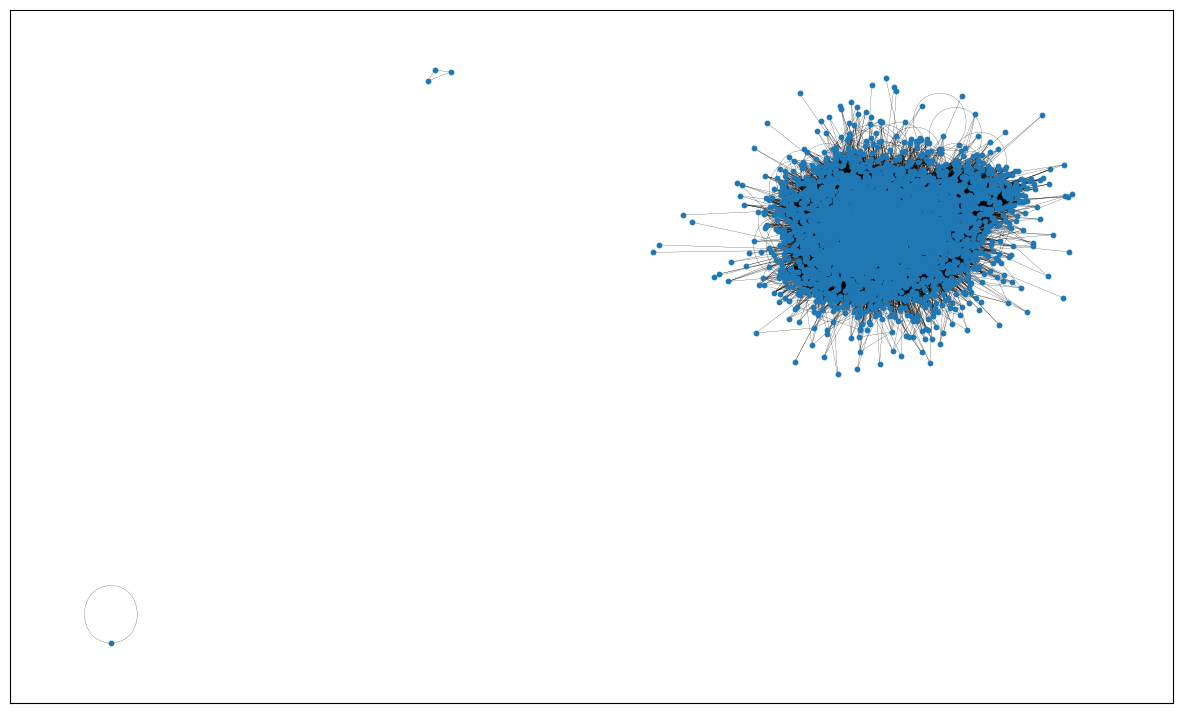

In [ ]:
plot_options = {"node_size": 10, "with_labels": False, "width": 0.15}
pos = nx.spring_layout(G, iterations=15, seed=1721)
fig, ax = plt.subplots(figsize=(15, 9))
nx.draw_networkx(G, pos=pos, ax=ax, **plot_options)

In [ ]:
print(list(G.nodes())[:10])  # Check first 10 node IDs


['%C3%81ed%C3%A1n_mac_Gabr%C3%A1in', 'Bede', 'Columba', 'D%C3%A1l_Riata', 'Great_Britain', 'Ireland', 'Isle_of_Man', 'Monarchy', 'Orkney', 'Picts']


In [ ]:
# Create the graph with overwrite enabled
G_adb = nxadb.MultiGraph(
    name="WikipediaLinks",
    db=db,
    incoming_graph_data=G,
    write_batch_size=50000,
    overwrite_graph=True
)

print(G_adb)


[17:12:55 +0000] [INFO]: Overwriting graph 'WikipediaLinks'
INFO:nx_arangodb:Overwriting graph 'WikipediaLinks'
[17:12:55 +0000] [INFO]: Graph 'WikipediaLinks' exists.
INFO:nx_arangodb:Graph 'WikipediaLinks' exists.
[17:12:55 +0000] [INFO]: Default node type set to 'WikipediaLinks_node'
INFO:nx_arangodb:Default node type set to 'WikipediaLinks_node'
[2025/03/09 17:12:55 +0000] [1481] [INFO] - adbnx_adapter: Instantiated ADBNX_Adapter with database '_system'
INFO:adbnx_adapter:Instantiated ADBNX_Adapter with database '_system'


Output()

Output()

[2025/03/09 17:12:58 +0000] [1481] [INFO] - adbnx_adapter: Created ArangoDB 'WikipediaLinks' Graph
INFO:adbnx_adapter:Created ArangoDB 'WikipediaLinks' Graph


MultiGraph named 'WikipediaLinks' with 4593 nodes and 0 edges


In [ ]:
# import urllib.parse

# def get_node_article_mapping(G):
#     """
#     Create a mapping between node IDs and article titles

#     Parameters:
#     G (networkx.Graph): The graph with node IDs

#     Returns:
#     dict: Mapping of node IDs to article titles
#     """
#     node_to_article = {}

#     # Assuming you have a way to access the original data
#     # This could be from your ArangoDB or from the original dataset
#     for node_id in G.nodes():
#         # Get node data from graph if it exists
#         node_data = G.nodes[node_id]

#         # If the node has an 'article' or 'title' attribute
#         if 'article' in node_data:
#             article_name = node_data['article']
#             node_to_article[node_id] = urllib.parse.unquote(article_name)
#         elif 'title' in node_data:
#             article_name = node_data['title']
#             node_to_article[node_id] = urllib.parse.unquote(article_name)

#     return node_to_article

In [ ]:
print(len(G_adb.nodes))  # Should print the number of nodes
print(list(G_adb.nodes())[:10])  # Print some node names


4593
['WikipediaLinks_node/540', 'WikipediaLinks_node/3066', 'WikipediaLinks_node/2845', 'WikipediaLinks_node/4521', 'WikipediaLinks_node/4366', 'WikipediaLinks_node/2686', 'WikipediaLinks_node/2729', 'WikipediaLinks_node/448', 'WikipediaLinks_node/538', 'WikipediaLinks_node/987']


In [ ]:
G_adb = nxadb.Graph(name="WikipediaLinks", db=db)

print(G_adb)

[17:12:59 +0000] [INFO]: Graph 'WikipediaLinks' exists.
INFO:nx_arangodb:Graph 'WikipediaLinks' exists.
[17:13:00 +0000] [INFO]: Default node type set to 'WikipediaLinks_node'
INFO:nx_arangodb:Default node type set to 'WikipediaLinks_node'


Graph named 'WikipediaLinks' with 4593 nodes and 6647 edges


In [ ]:
arango_graph = ArangoGraph(db)

In [ ]:
os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY")

In [ ]:
@tool
def text_to_aql_to_text(query: str):
  """This tool is available to invoke the
    ArangoGraphQAChain object, which enables you to
    translate a Natural Language Query into AQL, execute
    the query, and translate the result back into Natural Language.
    """
  llm = ChatOpenAI(temperature=0, model_name="gpt-4o")

  chain = ArangoGraphQAChain.from_llm(
    	llm=llm,
    	graph=arango_graph,
    	verbose=True,
        allow_dangerous_requests=True
    )
  result = chain.invoke(query)

  return str(result["result"])


This function will select the retrieval method from graph RAG based on the query

In [ ]:
def recommend_articles_from_graph(query):
    """This tool recommends Wikipedia articles based on a user query
    and the link structure of the ArangoDB Graph.

    - It interprets the query to determine the most relevant articles.
    - Uses NetworkX algorithms (PageRank, Personalized PageRank, etc.).
    - Returns a list of recommended articles.
    """

    llm = ChatOpenAI(temperature=0, model_name="gpt-4o")

    ######################
    print("1) Identifying Relevant Algorithm")

    text_to_nx = llm.invoke(f"""
    I have a directed NetworkX Graph called {G_adb} representing Wikipedia articles and their hyperlinks.

    **Graph Schema:**
    - **Nodes:** Wikipedia article titles.
    - **Edges:** Hyperlinks between articles (A → B means article A links to article B).
    - {arango_graph.schema}

    **User Query:** {query}

    **Task:** Identify the best algorithm to generate recommendations based on:
    - Similar articles based on link structure.
    - PageRank-based importance.
    - Articles frequently linked together.

    **Expected Output:**
    Return only the name of the best algorithm (e.g., "Personalized PageRank", "HITS", "Common Neighbors").
    Do not include any extra text.
    """).content.strip()

    print(f"Selected Algorithm: {text_to_nx}")

    FINAL_RESULT = get_recommendations(G=G_adb, method=text_to_nx, query_article=query, num_results=10)

    return FINAL_RESULT


Getting the correlated nodes and edges based on the query.

In [ ]:
def get_recommendations(G, method, query_article=None, num_results=10):
    """
    Generate article recommendations based on various graph algorithms.

    Parameters:
    G (networkx.Graph): The graph representing article relationships
    method (str): The recommendation algorithm to use
    query_article (str, optional): The source article for personalized recommendations
    num_results (int): Number of recommendations to return

    Returns:
    list: Recommended articles sorted by relevance
    """
    recommended_articles = []

    if method == "Personalized PageRank":
        if query_article and query_article in G:
            personalization = {query_article: 1.0}
            pr = nx.pagerank(G, personalization=personalization)
            # Remove the query article from recommendations
            if query_article in pr:
                pr.pop(query_article)
            recommended_articles = sorted(pr, key=pr.get, reverse=True)[:num_results]
        else:
            # Fallback to standard PageRank if query article is invalid
            pr = nx.pagerank(G)
            recommended_articles = sorted(pr, key=pr.get, reverse=True)[:num_results]

    elif method == "HITS":
        hubs, authorities = nx.hits(G)
        recommended_articles = sorted(authorities, key=authorities.get, reverse=True)[:num_results]

    elif method == "Common Neighbors":
        if query_article and query_article in G:
            neighbors = set(G.neighbors(query_article))
            candidates = {
                node: len(neighbors & set(G.neighbors(node)))
                for node in G.nodes if node != query_article
            }
            # Sort by number of common neighbors, and only include nodes with at least one common neighbor
            filtered_candidates = {node: count for node, count in candidates.items() if count > 0}
            if filtered_candidates:
                recommended_articles = sorted(filtered_candidates, key=filtered_candidates.get, reverse=True)[:num_results]
            else:
                # Fallback if no common neighbors found
                recommended_articles = list(G.neighbors(query_article))[:num_results]
        else:
            # Fallback to degree centrality if query article is invalid
            dc = nx.degree_centrality(G)
            recommended_articles = sorted(dc, key=dc.get, reverse=True)[:num_results]
    else:
        # Default to degree centrality if method not recognized
        dc = nx.degree_centrality(G)
        recommended_articles = sorted(dc, key=dc.get, reverse=True)[:num_results]

    return recommended_articles

Getting the correlated nodes and edges based on the query.

In [ ]:
# Define the tool for creating a mapping
def create_node_to_article_mapping(links_df: pd.DataFrame) -> dict:
    """
    Create a mapping between node ID numbers and article names.

    Parameters:
    links_df: DataFrame containing the original link data with linkSource and linkTarget.

    Returns:
    dict: Mapping of node numbers to article names.
    """
    all_articles = set(links_df['linkSource'].unique()) | set(links_df['linkTarget'].unique())
    article_list = sorted(list(map(str, all_articles)))
    node_to_article = {i: article for i, article in enumerate(article_list)}
    return node_to_article


# Define the tool for displaying recommendations
def display_readable_recommendations(recommended_ids: list, mapping: dict) -> list:
    """
    Convert node IDs to article titles and display recommendations.

    Parameters:
    recommended_ids: List of node IDs (e.g., ['WikipediaLinks_node/102', ...])
    mapping: Dictionary mapping node numbers to article names.

    Returns:
    list: Recommendations with human-readable article titles.
    """
    results = []
    for node_id in recommended_ids:
        numeric_id = int(node_id.split('/')[-1])  # Extract number part from ID

        if numeric_id in mapping:
            article_title = mapping[numeric_id]
            results.append({'id': node_id, 'article': article_title})
        else:
            results.append({'id': node_id, 'article': f"Unknown article (ID: {numeric_id})"})

    return results



This is the normal RAG, this will load the text, divide it by chunk size, add it to conver it to embeddings, and add it to FAISS vectorstore, and there is function for getting the context from the query from the vector store.

In [ ]:
def load_wikipedia_text(file_path):
    with open(file_path, "rb") as f:
      raw_data = f.read()
      detected_encoding = chardet.detect(raw_data)["encoding"]

    # Use the detected encoding
    loader = TextLoader(file_path, encoding=detected_encoding)
    docs = loader.load()
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100)
    split_docs = text_splitter.split_documents(docs)
    return split_docs

def create_faiss_index(docs):
    embeddings = OpenAIEmbeddings()
    vectorstore = FAISS.from_documents(docs, embeddings)
    return vectorstore

def search_wikipedia_faiss(vectorstore, query: str, k: int = 5):
    results = vectorstore.similarity_search(query, k=k)
    return [result.page_content for result in results]


This is the function for getting the summary, from the query, the context, and the correlated content

In [ ]:
def prompt_for_the_summary(query, context, graph_correlated):
    """
    Getting the query and getting the prompt

    - query (str): The search query
    - k (int): Number of top results to retrieve

    and utitlize the regenaration

    """
    llm = ChatOpenAI(temperature=0, model_name="gpt-4o")
    prompt = f"""
    You are an assistant that know about the wikipedia and you are asked by query and answer by context, and giving some explanation about the linked/corellated
    graph connection article from graph_correlated
    <Query>
    {query}
    </Query>

    <Context>
    {context}
    </Context>

    <Correlated>
    {graph_correlated}
    </Correlated>
    Return only the answer
    """

    return llm.invoke(prompt).content



this is the pipeline, this will running all the function needed for the response.

In [ ]:
def fix_pipeline(prompt):
    recommended_articles = recommend_articles_from_graph(prompt)

    if not isinstance(links, pd.DataFrame):
        raise TypeError("Expected a Pandas DataFrame but received a different type.")

    node_to_article = create_node_to_article_mapping(links)
    readable_recs = display_readable_recommendations(recommended_articles, node_to_article)
    related_list = [rec['article'] for rec in readable_recs]

    vectorstores = {}
    for rec in readable_recs:
        docs = load_wikipedia_text(f"/content/drive/MyDrive/plaintext_articles/{rec['article']}.txt")
        vectorstores[rec['article']] = create_faiss_index(docs)

    prompt_retrieval = []
    related_retrieval = []

    for vectorstore in vectorstores.values():
        prompt_retrieval.extend(search_wikipedia_faiss(vectorstore, prompt, k=5))
        related_retrieval.extend(search_wikipedia_faiss(vectorstore, " ".join(related_list), k=5))

    summary = prompt_for_the_summary(prompt, prompt_retrieval, related_retrieval)
    return summary

summary = fix_pipeline("What is the connection between Ireland and Great Britain")
print(summary)

1) Identifying Relevant Algorithm
Selected Algorithm: Personalized PageRank


[17:13:05 +0000] [INFO]: Graph 'WikipediaLinks' load took 0.32549190521240234s
INFO:nx_arangodb:Graph 'WikipediaLinks' load took 0.32549190521240234s
[17:13:09 +0000] [INFO]: NXCG Graph construction took 3.9276535511016846s
INFO:nx_arangodb:NXCG Graph construction took 3.9276535511016846s
<ipython-input-25-da405b3a7222>:14: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  embeddings = OpenAIEmbeddings()


Ireland and Great Britain are connected geographically as they are both part of the British Isles. Politically, Ireland is divided into two parts: the Republic of Ireland, which is an independent country, and Northern Ireland, which is part of the United Kingdom along with Great Britain. Historically, the two have shared a complex relationship, with Ireland being under British rule for several centuries before gaining independence for most of the island in the early 20th century.
